<a href="https://colab.research.google.com/github/francesco-vaccari/ProjectDL/blob/fra/Baseline_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
!tar -xf /content/refcocog.tar.gz
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-uizjmovl
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-uizjmovl
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=9a335dd29b184d17e4279791fec5074d10a064365c3c9184ce96f2eaf8b40d1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-l9u0882l/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /con

In [2]:
# General Variables
REFCOCOG_PATH = "refcocog"

## DATASET

In [3]:
import json
import clip
import torch
import pandas
import numpy as np

from torch.utils.data import Dataset, DataLoader
from typing import Sequence, Union

from PIL import Image, ImageDraw



class RefcocogDataset(Dataset):
    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area"]], left_on="ann_id", right_on="id") \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)
    
    def showImage(self, train_features, train_bbox):
        img = self.getImage(train_features)
        img1 = ImageDraw.Draw(img)
        img1.rectangle([(train_bbox[0].item(), train_bbox[1].item()), (train_bbox[2].item(), train_bbox[3].item())], outline ="red")
        img.show()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentences):
        return [f"a photo of {s['sent']}" for s in sentences]

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, item.bbox

In [4]:
if __name__ == "__main__":
    _, preprocess = clip.load("RN50")

    train_dataset = RefcocogDataset(REFCOCOG_PATH, split="train", transform=preprocess, tokenization=clip.tokenize)
    val_dataset = RefcocogDataset(REFCOCOG_PATH, split="val", transform=preprocess, tokenization=clip.tokenize)
    test_dataset = RefcocogDataset(REFCOCOG_PATH, split="test", transform=preprocess, tokenization=clip.tokenize)

    train_dataloader = DataLoader(train_dataset, shuffle=False)
    val_dataloader = DataLoader(val_dataset, shuffle=False)
    test_dataloader = DataLoader(test_dataset, shuffle=False)

100%|███████████████████████████████████████| 244M/244M [00:03<00:00, 74.9MiB/s]


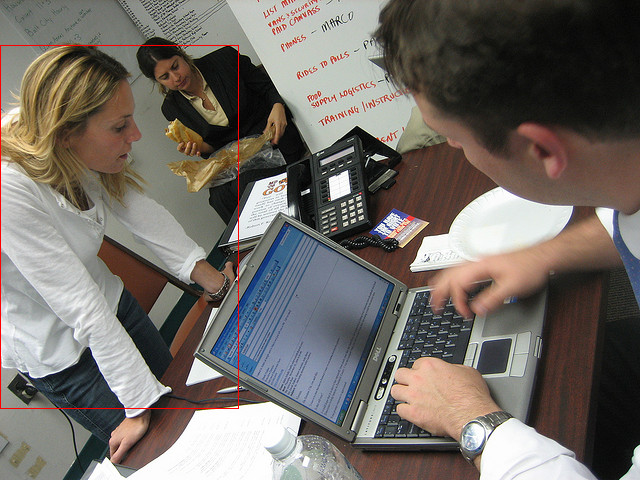

['a photo of two woman one in black eatting and the other has a white shirt at the desk', 'a photo of woman in white shirt looking down at laptop computer']
42226
2573
5023


In [5]:
train_features, train_bbox = next(iter(train_dataloader))
train_dataset.showImage(train_features, train_bbox)
print(train_dataset.getSentences(train_features))
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

## BASELINE

In [6]:
modelYOLO = torch.hub.load('ultralytics/yolov5', 'yolov5x')
device = "cuda" if torch.cuda.is_available() else "cpu"
modelCLIP, preprocessCLIP = clip.load("RN50", device=device)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-5-4 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


100%|██████████| 166M/166M [00:03<00:00, 56.5MB/s]

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [10]:
def YoloBBoxes(img, modelYOLO):
    result = modelYOLO(img)
    # result.show()
    bbox = result.pandas().xyxy[0]
    bbox = bbox.reset_index()
    bbox["tconfidence"] = np.nan
    bbox["crop"] = np.nan
    return bbox

def CropImage(image, boxs):
    crops = []
    for index, row in boxs.iterrows():
        box = (
            row['xmin'],
            row['ymin'],
            row['xmax'],
            row['ymax'],
        )
        crop = image.crop(box)
        crops.append(crop)
        boxs.at[index, 'crop'] = crop
    return crops

def computeSimilarity(image, sentences, modelCLIP, preprocessCLIP):
    similarities = []
    for sent in sentences:
        with torch.no_grad():
            image_features = modelCLIP.encode_image(torch.unsqueeze(preprocessCLIP(image).to(device), dim=0)).float().to(device)
            text_features = modelCLIP.encode_text(sent[0].to(device)).float().to(device)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarities.append(text_features.cpu().numpy() @ image_features.cpu().numpy().T)
    return sum(similarities)/len(similarities)

def computeIntersection(fx1, fy1, fx2, fy2, sx1, sy1, sx2, sy2):
    dx = min(fx2, sx2) - max(fx1, sx1)
    dy = min(fy2, sy2) - max(fy1, sy1)
    if (dx>=0) and (dy>=0):
        area = dx*dy
    else:
        area = 0
    return area

def computeAccuracy(bboxes, index, label):
    intersection = computeIntersection(bboxes['xmin'][index], bboxes['ymin'][index], bboxes['xmax'][index], bboxes['ymax'][index], 
                                       label[0].item(), label[1].item(), label[0].item()+label[2].item(), label[1].item()+label[3].item())
    area1 = (bboxes['xmax'][index]-bboxes['xmin'][index])*(bboxes['ymax'][index]-bboxes['ymin'][index])
    area2 = label[2].item()*label[3].item()
    union = area1 + area2 - intersection
    return intersection / union

In [11]:
def baseline(loader, dataset, modelYOLO, modelCLIP, preprocessCLIP):
    n_samples = 0
    tot_accuracy = 0
    for data_features, data_bbox in loader:

        bboxes = YoloBBoxes(dataset.getImage(data_features), modelYOLO)
        crops = CropImage(dataset.getImage(data_features), bboxes)


        if len(crops) > 0:
            highest_similarity = 0
            index_pred = 0
            for i, crop in enumerate(crops):
                similarity = computeSimilarity(crop, data_features['sentences'], modelCLIP, preprocessCLIP)
                if similarity > highest_similarity:
                    highest_similarity = similarity
                    index_pred = i
        
            accuracy = computeAccuracy(bboxes, index_pred, data_bbox)
        else:
            accuracy = 0
        
        tot_accuracy += accuracy
        n_samples += 1
        print(f'Image {n_samples:^8}/{len(dataset):^8}\t{accuracy}')

    return tot_accuracy/n_samples

In [12]:
baseline(test_dataloader, test_dataset, modelYOLO, modelCLIP, preprocessCLIP)

Output streaming troncato alle ultime 5000 righe.
Image    24   /  5023  	0.8480459883423583
Image    25   /  5023  	0.0
Image    26   /  5023  	0.11992528795559157
Image    27   /  5023  	0.9314647408202215
Image    28   /  5023  	0.9480531834166529
Image    29   /  5023  	0.9482302045495286
Image    30   /  5023  	0.9249612095369457
Image    31   /  5023  	0.03949926731386079
Image    32   /  5023  	0.915841658420165
Image    33   /  5023  	0.955823702957967
Image    34   /  5023  	0.9697639085438311
Image    35   /  5023  	0.18041199708761554
Image    36   /  5023  	0.9662908230154014
Image    37   /  5023  	0.9668856155048486
Image    38   /  5023  	0.11949055497671424
Image    39   /  5023  	0.020742337384852517
Image    40   /  5023  	0.8820950741761707
Image    41   /  5023  	0.15481053185532356
Image    42   /  5023  	0.9587310535604185
Image    43   /  5023  	0.06484085330293331
Image    44   /  5023  	0.9230470372196958
Image    45   /  5023  	0.05831590424089284
Image    46 

0.5936768500110814